# Plot Curvature of a ResNet

In [17]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from utils_henaff import *
#import timm
import torchvision
import torchvision.models as models
from torchvision import transforms
import os
import sys

%load_ext autoreload
from fast_curvature import *

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# setting path
sys.path.append('../../straightening_models/adv_robust_cnn/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Video

In [18]:
vid = load_all_henaff_videos_corrected(img_size=224,rgb=True,imagenet=False)
videos = [vid['natural'].float().contiguous().to(device),
          vid['contrast'].float().contiguous().to(device), 
          vid['artificial'].float().contiguous().to(device)]

natural
contrast
artificial


# VOneNet ResNet50

In [19]:
from torchvision.models import resnet50
from torchvision.models import ResNet50_Weights

## ResNet50
model_arch = 'resnet50_v1'
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2) # I think this should be V1 not V2?
model = model.to(device)

model.eval();

ImportError: cannot import name 'ResNet50_Weights' from 'torchvision.models' (/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/torchvision/models/__init__.py)

In [4]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total params: ', pytorch_total_params)

Total params:  25557032


In [5]:
model_blocks = [model.conv1,
                model.bn1,
                model.relu,
                model.maxpool,
                model.layer1,
                model.layer2,
                model.layer3,
                model.layer4,
                model.avgpool,
               ]

In [6]:
curvs_natural = get_intermediate_curv(model, model_blocks,videos[0])
curvs_contrast = get_intermediate_curv(model, model_blocks,videos[1])
curvs_artificial = get_intermediate_curv(model, model_blocks,videos[2])

mean_natural = curvs_natural.mean(0)
mean_contrast = curvs_contrast.mean(0)
mean_artificial = curvs_artificial.mean(0)

ste_natural = curvs_natural.std(0)/curvs_natural.size(0)**0.5
ste_contrast = curvs_contrast.std(0)/curvs_contrast.size(0)**0.5
ste_artificial = curvs_artificial.std(0)/curvs_artificial.size(0)**0.5

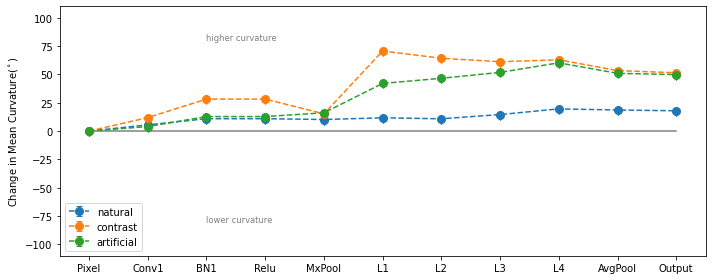

In [7]:
natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

xlabels = ['Pixel', 'Conv1', 'BN1', 'Relu','MxPool','L1','L2','L3','L4','AvgPool','Output']
output_dir = './resnet50_curves'
os.makedirs(output_dir,exist_ok=True)

all_curves = {'layer_names':xlabels,'natural_curves':mean_natural, 'contrast_curves':mean_contrast,'artificial_curves':mean_artificial,
              'natural_ste':ste_natural, 'contrast_ste':ste_contrast,'artificial_ste':ste_artificial}

plt.figure(figsize=(10,4))
plt.errorbar(xlabels, natural_plot, yerr=ste_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=ste_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=ste_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-110, 110])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[2], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[2], 80,'higher curvature', color='gray',fontsize='small')
plt.legend(loc='lower left')
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
name = f'vonenet_{model_arch}'
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
plt.savefig(save_name,dpi=300)
write_model_csv(output_dir, name, all_curves)

# ResNet50 - Downloaded Pretrained

In [3]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from utils_henaff import *
#import timm
import torchvision
import torchvision.models as models
from torchvision import transforms
import os
import sys

%load_ext autoreload
from fast_curvature import *

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# setting path
sys.path.append('../../straightening_models/adv_robust_cnn/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Video

In [20]:
vid = load_all_henaff_videos_corrected(img_size=224,rgb=True,imagenet=False)
videos = [vid['natural'].float().contiguous().to(device),
          vid['contrast'].float().contiguous().to(device), 
          vid['artificial'].float().contiguous().to(device)]

natural
contrast
artificial


## Pretrained ResNet50

In [31]:
from torchvision.models import resnet50
#from torchvision.models import ResNet50_Weights

## ResNet50
model_arch = 'resnet50_v1_dl'

#model = torch.load('../../straightening_models/adv_robust_cnn/resnet50-pytorch-pretrained.pth')
model = resnet50() 
model.load_state_dict(torch.load('../../straightening_models/adv_robust_cnn/resnet50-pytorch-pretrained.pth'))
model.eval()
model = model.to(device)

In [32]:
model_blocks = [model.conv1,
                model.bn1,
                model.relu,
                model.maxpool,
                model.layer1,
                model.layer2,
                model.layer3,
                model.layer4,
                model.avgpool,
               ]

In [33]:
curvs_natural = get_intermediate_curv(model, model_blocks,videos[0])
curvs_contrast = get_intermediate_curv(model, model_blocks,videos[1])
curvs_artificial = get_intermediate_curv(model, model_blocks,videos[2])

mean_natural = curvs_natural.mean(0)
mean_contrast = curvs_contrast.mean(0)
mean_artificial = curvs_artificial.mean(0)

ste_natural = curvs_natural.std(0)/curvs_natural.size(0)**0.5
ste_contrast = curvs_contrast.std(0)/curvs_contrast.size(0)**0.5
ste_artificial = curvs_artificial.std(0)/curvs_artificial.size(0)**0.5

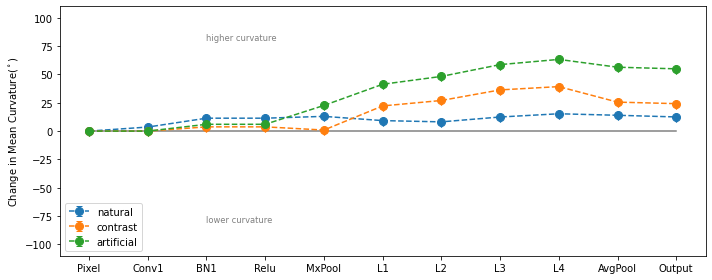

In [34]:
natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

xlabels = ['Pixel', 'Conv1', 'BN1', 'Relu','MxPool','L1','L2','L3','L4','AvgPool','Output']
output_dir = './resnet50_curves'
os.makedirs(output_dir,exist_ok=True)

all_curves = {'layer_names':xlabels,'natural_curves':mean_natural, 'contrast_curves':mean_contrast,'artificial_curves':mean_artificial,
              'natural_ste':ste_natural, 'contrast_ste':ste_contrast,'artificial_ste':ste_artificial}

plt.figure(figsize=(10,4))
plt.errorbar(xlabels, natural_plot, yerr=ste_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=ste_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=ste_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-110, 110])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[2], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[2], 80,'higher curvature', color='gray',fontsize='small')
plt.legend(loc='lower left')
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
name = f'pretrained_{model_arch}'
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
plt.savefig(save_name,dpi=300)
write_model_csv(output_dir, name, all_curves)

# ResNet50 - ImagenetLl2_3_0 Downloaded

In [35]:
# robust
name = 'resnet50'
model = models.__dict__[name](pretrained=False)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model_arch = 'imagenet_l2_3_0'
checkpoint = torch.load(f'../../straightening_models/adv_robust_cnn/{model_arch}.pt')

from collections import OrderedDict
new_state_dict1 = OrderedDict()
i= 0
for k, v in checkpoint['model'].items():
    if i == 0 or i == 1:
        i = i + 1
        continue
    if i>321:
        i = i + 1
        continue
    name =  k[13:] # remove `module.`
    new_state_dict1[name] = v
    i = i + 1

model.load_state_dict(new_state_dict1)
model = model.to(device)
model.eval();

In [36]:
# from torchvision.models import resnet50
# #from torchvision.models import ResNet50_Weights

# ## ResNet50
# model_arch = 'imagenet_l2_3_0'

# #model = torch.load('../../straightening_models/adv_robust_cnn/resnet50-pytorch-pretrained.pth')
# model = resnet50() 
# model.load_state_dict(torch.load(f'../../straightening_models/adv_robust_cnn/{model_arch}.pt'))
# model.eval()
# model = model.to(device)

In [37]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total params: ', pytorch_total_params)

Total params:  25557032


In [38]:
model_blocks = [model.conv1,
                model.bn1,
                model.relu,
                model.maxpool,
                model.layer1,
                model.layer2,
                model.layer3,
                model.layer4,
                model.avgpool,
               ]

In [39]:
curvs_natural = get_intermediate_curv(model, model_blocks,videos[0])
curvs_contrast = get_intermediate_curv(model, model_blocks,videos[1])
curvs_artificial = get_intermediate_curv(model, model_blocks,videos[2])

mean_natural = curvs_natural.mean(0)
mean_contrast = curvs_contrast.mean(0)
mean_artificial = curvs_artificial.mean(0)

ste_natural = curvs_natural.std(0)/curvs_natural.size(0)**0.5
ste_contrast = curvs_contrast.std(0)/curvs_contrast.size(0)**0.5
ste_artificial = curvs_artificial.std(0)/curvs_artificial.size(0)**0.5

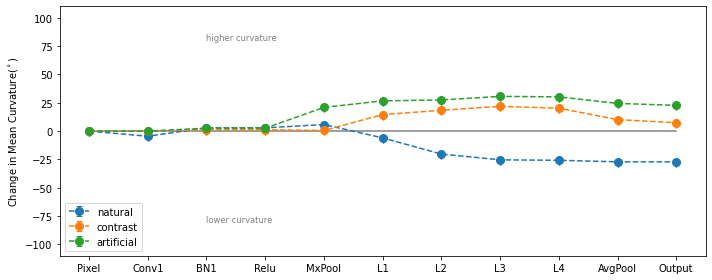

In [40]:
natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

xlabels = ['Pixel', 'Conv1', 'BN1', 'Relu','MxPool','L1','L2','L3','L4','AvgPool','Output']
output_dir = './resnet50_curves'
os.makedirs(output_dir,exist_ok=True)

all_curves = {'layer_names':xlabels,'natural_curves':mean_natural, 'contrast_curves':mean_contrast,'artificial_curves':mean_artificial,
              'natural_ste':ste_natural, 'contrast_ste':ste_contrast,'artificial_ste':ste_artificial}

plt.figure(figsize=(10,4))
plt.errorbar(xlabels, natural_plot, yerr=ste_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=ste_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=ste_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-110, 110])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[2], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[2], 80,'higher curvature', color='gray',fontsize='small')
plt.legend(loc='lower left')
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
name = f'robust_{model_arch}'
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
plt.savefig(save_name,dpi=300)
write_model_csv(output_dir, name, all_curves)

# ResNet50 - Imagenet_linf_4 Downloaded

## ResNet50

In [41]:
from torchvision.models import resnet50
#from torchvision.models import ResNet50_Weights

## ResNet50
model_arch = 'imagenet_linf_4'

# robust
name = 'resnet50'
model = models.__dict__[name](pretrained=False)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

checkpoint = torch.load(f'../../straightening_models/adv_robust_cnn/{model_arch}.pt')

from collections import OrderedDict
new_state_dict1 = OrderedDict()
i= 0
for k, v in checkpoint['model'].items():
    if i == 0 or i == 1:
        i = i + 1
        continue
    if i>321:
        i = i + 1
        continue
    name =  k[13:] # remove `module.`
    new_state_dict1[name] = v
    i = i + 1

model.load_state_dict(new_state_dict1)
model = model.to(device)
model.eval();

In [42]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total params: ', pytorch_total_params)

Total params:  25557032


In [43]:
model_blocks = [model.conv1,
                model.bn1,
                model.relu,
                model.maxpool,
                model.layer1,
                model.layer2,
                model.layer3,
                model.layer4,
                model.avgpool,
               ]

In [44]:
curvs_natural = get_intermediate_curv(model, model_blocks,videos[0])
curvs_contrast = get_intermediate_curv(model, model_blocks,videos[1])
curvs_artificial = get_intermediate_curv(model, model_blocks,videos[2])

mean_natural = curvs_natural.mean(0)
mean_contrast = curvs_contrast.mean(0)
mean_artificial = curvs_artificial.mean(0)

ste_natural = curvs_natural.std(0)/curvs_natural.size(0)**0.5
ste_contrast = curvs_contrast.std(0)/curvs_contrast.size(0)**0.5
ste_artificial = curvs_artificial.std(0)/curvs_artificial.size(0)**0.5

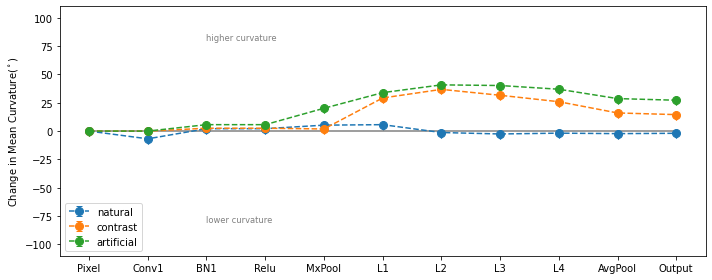

In [45]:
natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

xlabels = ['Pixel', 'Conv1', 'BN1', 'Relu','MxPool','L1','L2','L3','L4','AvgPool','Output']
output_dir = './resnet50_curves'
os.makedirs(output_dir,exist_ok=True)

all_curves = {'layer_names':xlabels,'natural_curves':mean_natural, 'contrast_curves':mean_contrast,'artificial_curves':mean_artificial,
              'natural_ste':ste_natural, 'contrast_ste':ste_contrast,'artificial_ste':ste_artificial}

plt.figure(figsize=(10,4))
plt.errorbar(xlabels, natural_plot, yerr=ste_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=ste_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=ste_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-110, 110])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[2], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[2], 80,'higher curvature', color='gray',fontsize='small')
plt.legend(loc='lower left')
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
name = f'robust_{model_arch}'
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
plt.savefig(save_name,dpi=300)
write_model_csv(output_dir, name, all_curves)

# ResNet50 - Imagenet_linf_8 Downloaded

## VOneNet ResNet50

In [46]:
from torchvision.models import resnet50
#from torchvision.models import ResNet50_Weights

## ResNet50
model_arch = 'imagenet_linf_8'

# robust
name = 'resnet50'
model = models.__dict__[name](pretrained=False)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
checkpoint = torch.load(f'../../straightening_models/adv_robust_cnn/{model_arch}.pt')

from collections import OrderedDict
new_state_dict1 = OrderedDict()
i= 0
for k, v in checkpoint['model'].items():
    if i == 0 or i == 1:
        i = i + 1
        continue
    if i>321:
        i = i + 1
        continue
    name =  k[13:] # remove `module.`
    new_state_dict1[name] = v
    i = i + 1

model.load_state_dict(new_state_dict1)
model = model.to(device)
model.eval();

In [47]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total params: ', pytorch_total_params)

Total params:  25557032


In [48]:
model_blocks = [model.conv1,
                model.bn1,
                model.relu,
                model.maxpool,
                model.layer1,
                model.layer2,
                model.layer3,
                model.layer4,
                model.avgpool,
               ]

In [49]:
curvs_natural = get_intermediate_curv(model, model_blocks,videos[0])
curvs_contrast = get_intermediate_curv(model, model_blocks,videos[1])
curvs_artificial = get_intermediate_curv(model, model_blocks,videos[2])

mean_natural = curvs_natural.mean(0)
mean_contrast = curvs_contrast.mean(0)
mean_artificial = curvs_artificial.mean(0)

ste_natural = curvs_natural.std(0)/curvs_natural.size(0)**0.5
ste_contrast = curvs_contrast.std(0)/curvs_contrast.size(0)**0.5
ste_artificial = curvs_artificial.std(0)/curvs_artificial.size(0)**0.5

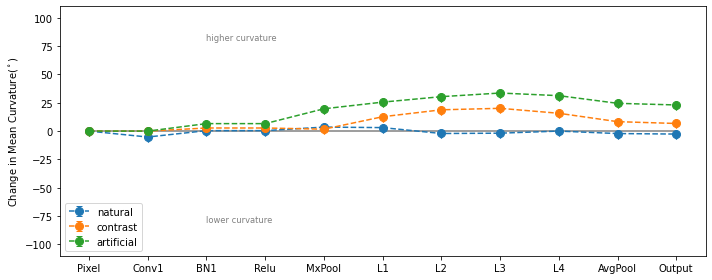

In [50]:
natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

xlabels = ['Pixel', 'Conv1', 'BN1', 'Relu','MxPool','L1','L2','L3','L4','AvgPool','Output']
output_dir = './resnet50_curves'
os.makedirs(output_dir,exist_ok=True)

all_curves = {'layer_names':xlabels,'natural_curves':mean_natural, 'contrast_curves':mean_contrast,'artificial_curves':mean_artificial,
              'natural_ste':ste_natural, 'contrast_ste':ste_contrast,'artificial_ste':ste_artificial}

plt.figure(figsize=(10,4))
plt.errorbar(xlabels, natural_plot, yerr=ste_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=ste_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=ste_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-110, 110])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[2], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[2], 80,'higher curvature', color='gray',fontsize='small')
plt.legend(loc='lower left')
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
name = f'robust_{model_arch}'
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
plt.savefig(save_name,dpi=300)
write_model_csv(output_dir, name, all_curves)